In [59]:
import os
import random

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models

import numpy as np
import matplotlib.pyplot as plt
import cv2

import sys

sys.path.append("generative_inpainting_pytorch")
from generative_inpainting_pytorch.model.networks import Generator
from generative_inpainting_pytorch.utils.tools import (
    get_config,
    is_image_file,
    default_loader,
    normalize,
    get_model_list,
)

In [60]:
config_file = "generative_inpainting_pytorch/configs/config.yaml"
config = get_config(config_file)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_dir = ""
images = [
    "test1.jpg",
    "test2.jpg",
    "test3.jpg",
]

# load in raw images
raw_imgs = []
original_sizes = []
resized_imgs = []
for i in range(len(images)):
    img_file = os.path.join(image_dir, images[i])
    assert is_image_file(img_file), f"{img_file} is not an image file"
    raw_img = default_loader(img_file)
    raw_imgs.append(raw_img)
    original_sizes.append(raw_img.size)
    resized_img = transforms.Resize(config["image_shape"][:-1])(raw_img)
    resized_imgs.append(resized_img)

## segmentation

In [61]:
class ClassLabels:
    background = 0
    aeroplane = 1
    bicycle = 2
    bird = 3
    boat = 4
    bottle = 5
    bus = 6
    car = 7
    cat = 8
    chair = 9
    cow = 10
    diningtable = 11
    dog = 12
    horse = 13
    motorbike = 14
    person = 15
    pottedplant = 16
    sheep = 17
    sofa = 18
    train = 19
    tvmonitor = 20
    NUM_CLASSES = 21

# Load a pre-trained DeepLabV3 model
# `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights
model = models.segmentation.deeplabv3_resnet101(
    weights="DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1"
)
model.eval()
model.to(device)

seg_preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [62]:
input_tensors = []
for i in range(len(resized_imgs)):
    processed_tensor = seg_preprocess(resized_imgs[i])
    input_tensors.append(processed_tensor)

input_batch = torch.stack(input_tensors).to(device)

with torch.no_grad():
    output = model(input_batch)["out"]
output_predictions = output.argmax(1)  # Get predictions for each image in the batch

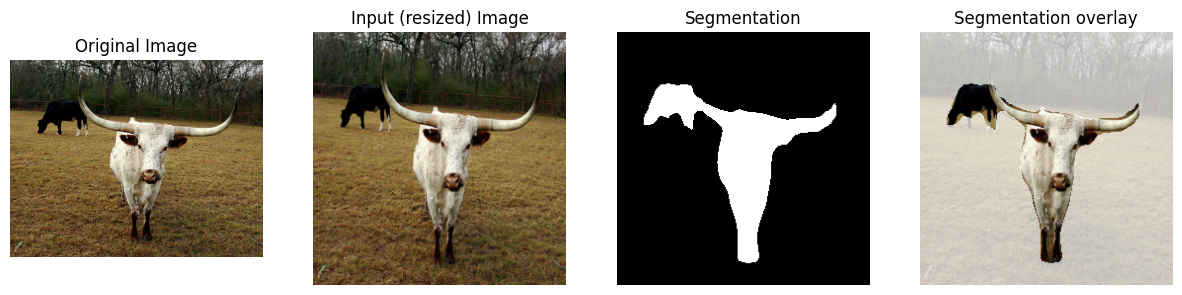

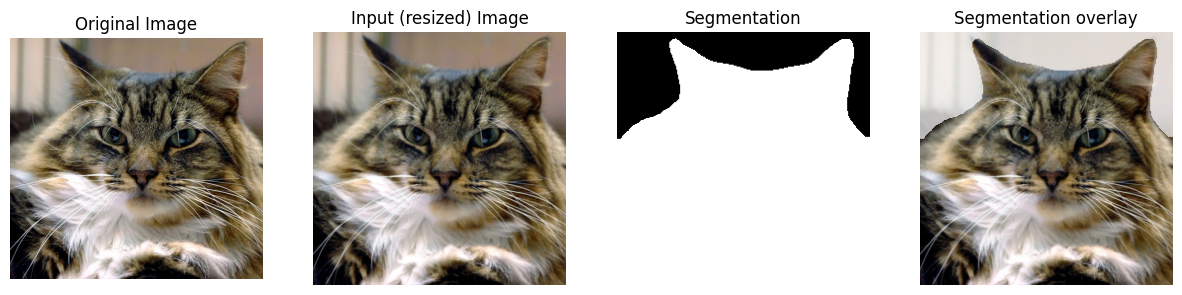

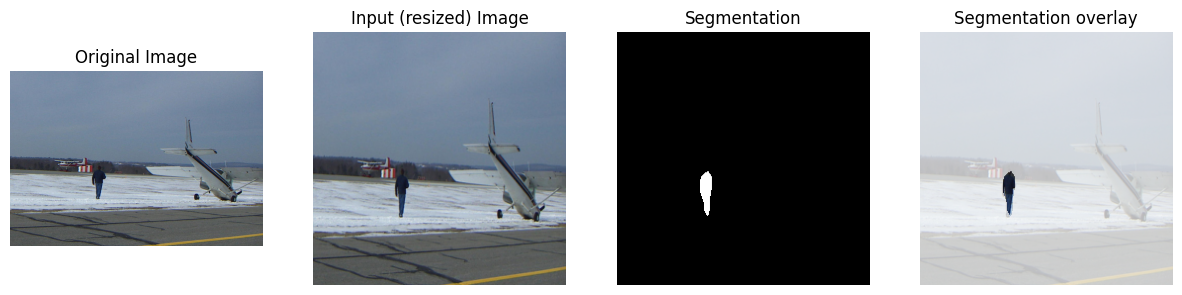

In [63]:
def get_masks_by_class(predictions, target_class=15):
    if isinstance(target_class, list):
        assert len(predictions) == len(target_class)
        res = []
        for i in range(len(predictions)):
            label_colors = torch.zeros((ClassLabels.NUM_CLASSES, 1)).to(device)
            label_colors[target_class[i]] = 1  # Class Person change to white
            res.append(label_colors[predictions[i]])
        res = torch.stack(res).to(device)
    else:
        label_colors = torch.zeros((ClassLabels.NUM_CLASSES, 1)).to(device)
        label_colors[target_class] = 1  # Class Person change to white
        res = label_colors[predictions]
    return res


target_classes = [ClassLabels.cow, ClassLabels.cat, ClassLabels.person]
segmentations_tensor = get_masks_by_class(
    output_predictions, target_class=target_classes
)
segmentations = segmentations_tensor.cpu().numpy()

for i, segmentation in enumerate(segmentations):

    fig, ax = plt.subplots(1, 4, figsize=(15, 6))

    ax[0].set_title(f"Original Image")
    ax[0].imshow(raw_imgs[i])
    ax[0].axis("off")

    ax[1].set_title(f"Input (resized) Image")
    ax[1].imshow(resized_imgs[i])
    ax[1].axis("off")

    ax[2].set_title(f"Segmentation")
    ax[2].imshow(segmentation, cmap="gray")
    ax[2].axis("off")

    ax[3].set_title(f"Segmentation overlay")
    alpha_mask = np.where(segmentation > 0, 1, 0.3)
    rgba_img = np.concatenate((np.array(resized_imgs[i])/255, alpha_mask), axis=2)
    ax[3].imshow(rgba_img)
    # ax[3].imshow(resized_imgs[i], alpha=segmentation.squeeze())  # TODO: doesn't work
    # ax[3].imshow(resized_imgs[i])
    # ax[3].imshow(segmentation, alpha=0.5, cmap="gray")
    ax[3].axis("off")

    plt.show()

## generative inpainting

In [64]:
def predict(images, masks, config, default_seed=None, train_iter=0):
    """
    images: tensor of shape (batch_size, 3, H, W)
    masks: tensor of shape (batch_size, 1, H, W)
    """
    # CUDA configuration
    cuda = config["cuda"]
    device_ids = config["gpu_ids"]
    if cuda:
        os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(str(i) for i in device_ids)
        device_ids = list(range(len(device_ids)))
        config["gpu_ids"] = device_ids

    # Set random seed
    if default_seed is None:
        default_seed = random.randint(1, 10000)
    random.seed(default_seed)
    torch.manual_seed(default_seed)
    if cuda:
        torch.cuda.manual_seed_all(default_seed)

    checkpoint_path = os.path.join(
        "generative_inpainting_pytorch",
        "checkpoints",
        config["dataset_name"],
        config["mask_type"] + "_" + config["expname"],
    )
    with torch.no_grad():
        # Define the model
        netG = Generator(config["netG"], cuda, device_ids)
        # Resume weight
        last_model_name = get_model_list(checkpoint_path, "gen", iteration=train_iter)
        netG.load_state_dict(torch.load(last_model_name))

        if cuda:
            netG = nn.parallel.DataParallel(netG, device_ids=device_ids)
            images = images.cuda()
            masks = masks.cuda()

        # Inference
        x1, x2, offset_flow = netG(images, masks)
        inpainted_result = x2 * masks + images * (1.0 - masks)

    # normalize the inpainted result to [0, 1]
    inpainted_result = inpainted_result.detach().cpu().numpy()
    inpainted_result = (inpainted_result + 1) / 2.0
    return inpainted_result


# dilate the masks
dilated_masks = []
kernel = np.ones((5, 5), np.uint8)
# segmentations_tensor.shape = (batch_size, H, W, 1)
for mask in segmentations_tensor:
    original_mask = mask.cpu().squeeze().numpy()
    dilated_mask = cv2.dilate(original_mask, kernel, iterations=2)
    _, dilated_mask = cv2.threshold(dilated_mask, 0.5, 1, cv2.THRESH_BINARY)
    dilated_masks.append(torch.tensor(dilated_mask).unsqueeze(0))
masks = torch.stack(dilated_masks).to(device)

# preprocess the images
inpaint_preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        normalize,
    ]
)
input_tensors = []
for i in range(len(resized_imgs)):
    processed_tensor = inpaint_preprocess(resized_imgs[i])
    input_tensor = processed_tensor.to(device) * (1.0 - masks[i])
    input_tensors.append(input_tensor)

input_batch = torch.stack(input_tensors).to(device)

# inpaint the images
res_imgs = predict(input_batch, masks, config)

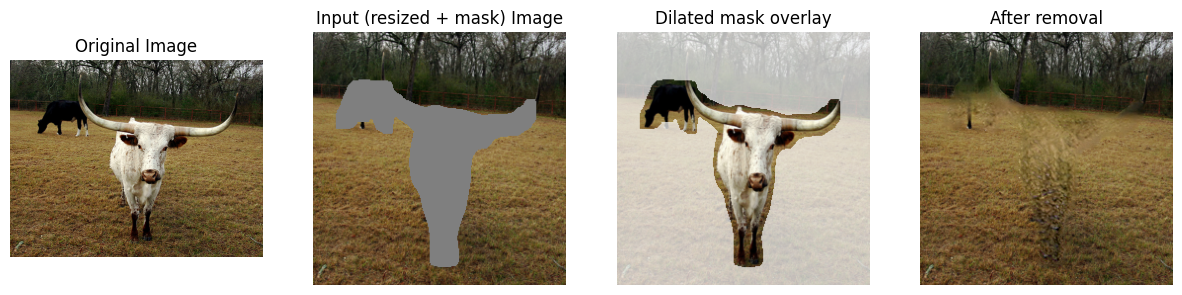

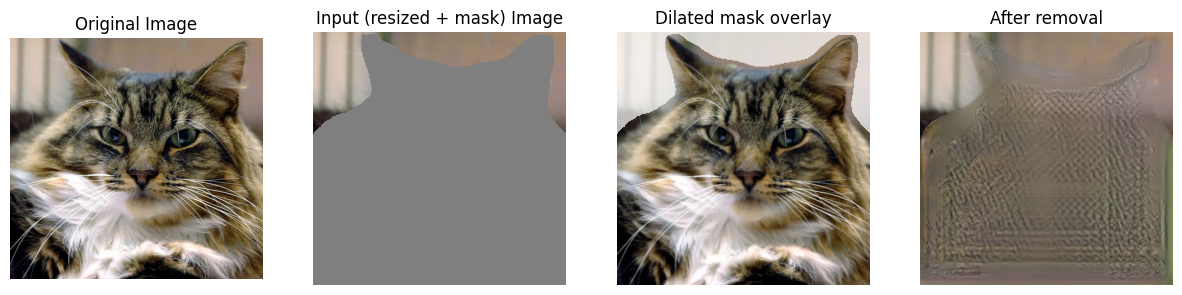

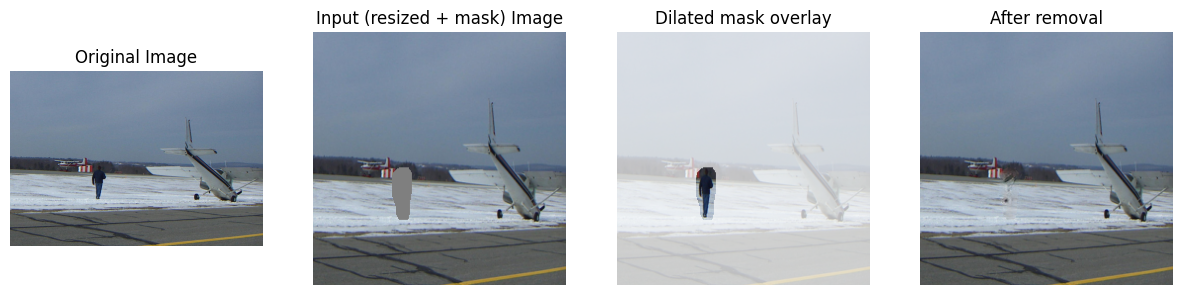

In [65]:
for i, res_img in enumerate(res_imgs):
    fig, ax = plt.subplots(1, 4, figsize=(15, 6))

    ax[0].set_title(f"Original Image")
    ax[0].imshow(raw_imgs[i])
    ax[0].axis("off")

    ax[1].set_title(f"Input (resized + mask) Image")
    ax[1].imshow(((input_tensors[i] + 1) / 2).cpu().permute(1, 2, 0).numpy())
    ax[1].axis("off")

    ax[2].set_title(f"Dilated mask overlay")
    alpha_mask = np.where(dilated_masks[i].permute(1, 2, 0).cpu().numpy() > 0, 1, 0.3)
    rgba_img = np.concatenate((np.array(resized_imgs[i])/255, alpha_mask), axis=2)
    ax[2].imshow(rgba_img)
    ax[2].axis("off")

    ax[3].set_title(f"After removal")
    ax[3].imshow(res_img.transpose(1, 2, 0))
    ax[3].axis("off")

    plt.show()

## Image after removal

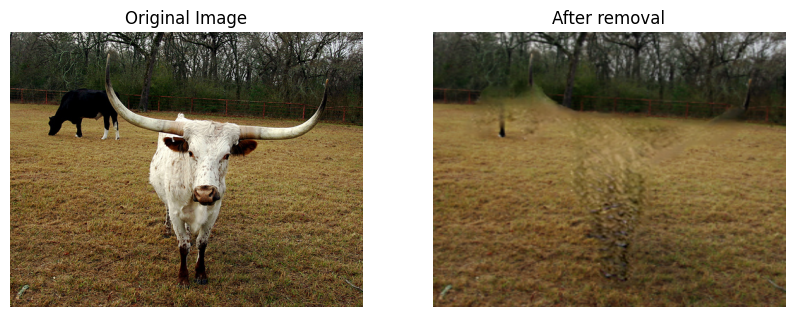

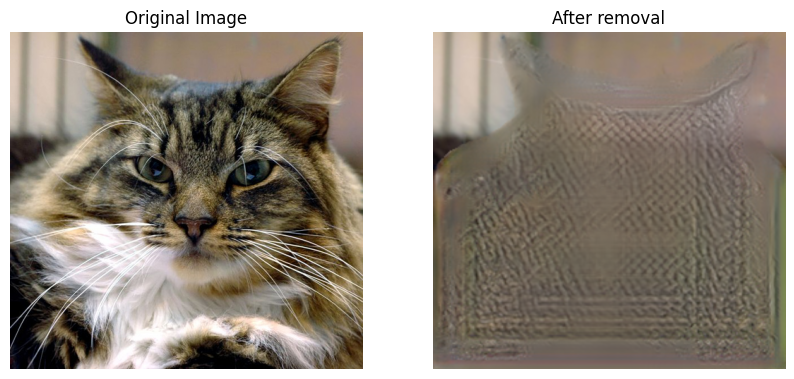

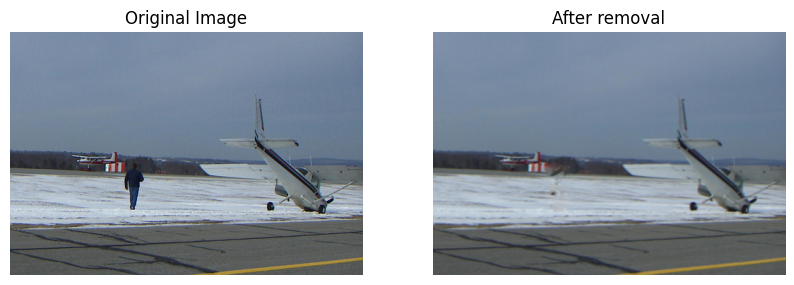

In [66]:
for i, res_img in enumerate(res_imgs):
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))

    ax[0].set_title(f"Original Image")
    ax[0].imshow(raw_imgs[i])
    ax[0].axis("off")

    ax[1].set_title(f"After removal")
    resize_img = transforms.Resize(original_sizes[i][::-1])(torch.tensor(res_img))
    ax[1].imshow(resize_img.permute(1, 2, 0).numpy())
    ax[1].axis("off")
    plt.show()

## Testing by Reusing the Segmentation Model
This section tests whether the combination of the 2 models is able to remove the requested classes. For this section, we test the effectiveness of the removal by passing the inpainted images back through the segmentation model. If the label we intend to remove no longer exist in the predicted image, we then consider the removal to be successful.

In [67]:
import xml.etree.ElementTree as ET
num_imgages_to_test = 30

# need to change path to the VOC2012_test folder
annotation_path = r"C:\Users\xmzsi\Downloads\archive\VOC2012_test\VOC2012_test\Annotations"
images_path = r"C:\Users\xmzsi\Downloads\archive\VOC2012_test\VOC2012_test\JPEGImages"

PASCAL_VOC_LABELS = {
    0: 'background',
    1: 'aeroplane',
    2: 'bicycle',
    3: 'bird',
    4: 'boat',
    5: 'bottle',
    6: 'bus',
    7: 'car',
    8: 'cat',
    9: 'chair',
    10: 'cow',
    11: 'diningtable',
    12: 'dog',
    13: 'horse',
    14: 'motorbike',
    15: 'person',
    16: 'pottedplant',
    17: 'sheep',
    18: 'sofa',
    19: 'train',
    20: 'tvmonitor',
}
obj_to_idx = {v: k for k, v in PASCAL_VOC_LABELS.items()}

# get the filename and the label of the first object in the annotation file
def parse_annotations(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    label=root.find("object").find("name").text
    return label

labels = []
label_indices = []
raw_imgs_for_seg_testing = []
resized_imgs_for_seg_testing = []
img_count = 0
for filename in os.listdir(annotation_path):
    if filename.endswith(".xml"):
        file_path = os.path.join(annotation_path, filename)
        image_name = filename[:-4] + '.jpg'
        image_path = os.path.join(images_path, image_name)
        label = parse_annotations(file_path)
        labels.append(label)

        raw_img = default_loader(image_path)
        raw_imgs_for_seg_testing.append(raw_img)
        resized_img = transforms.Resize(config["image_shape"][:-1])(raw_img)
        resized_imgs_for_seg_testing.append(resized_img)
    img_count += 1
    if img_count == num_imgages_to_test:
        break

for i in range(len(labels)):
    if labels[i] in obj_to_idx:
        label_indices.append(obj_to_idx[labels[i]])
    else:
        label_indices.append(0)


input_tensors = []
for i in range(len(resized_imgs_for_seg_testing)):
    processed_tensor = seg_preprocess(resized_imgs_for_seg_testing[i])
    input_tensors.append(processed_tensor)

input_batch = torch.stack(input_tensors).to(device)

with torch.no_grad():
    output = model(input_batch)["out"]
output_predictions = output.argmax(1)  # Get predictions for each image in the batch

segmentations_tensor = get_masks_by_class(
    output_predictions, target_class=label_indices
)
segmentations = segmentations_tensor.cpu().numpy()

# dilate the masks
dilated_masks = []
kernel = np.ones((5, 5), np.uint8)
# segmentations_tensor.shape = (batch_size, H, W, 1)
for mask in segmentations_tensor:
    original_mask = mask.cpu().squeeze().numpy()
    dilated_mask = cv2.dilate(original_mask, kernel, iterations=2)
    _, dilated_mask = cv2.threshold(dilated_mask, 0.5, 1, cv2.THRESH_BINARY)
    dilated_masks.append(torch.tensor(dilated_mask).unsqueeze(0))
masks = torch.stack(dilated_masks).to(device)


input_tensors = []
for i in range(len(resized_imgs_for_seg_testing)):
    processed_tensor = inpaint_preprocess(resized_imgs_for_seg_testing[i])
    input_tensor = processed_tensor.to(device) * (1.0 - masks[i])
    input_tensors.append(input_tensor)

input_batch = torch.stack(input_tensors).to(device)

# inpaint the images
res_imgs = predict(input_batch, masks, config)

# feed the images back to the segmentation model
input_tensors = []
for i in range(len(resized_imgs_for_seg_testing)):
    processed_tensor = seg_preprocess(resized_imgs_for_seg_testing[i])
    input_tensors.append(processed_tensor)

input_batch = torch.stack(input_tensors).to(device)

with torch.no_grad():
    output = model(input_batch)["out"]
output_predictions = output.argmax(1)

# check that the labels no longer exist
correct = 0
total = len(output_predictions)
for i in range(total):
    for row in output_predictions[i]:
        for col in row:
            found_label = False
            # still found the same label, so incorrect
            if col == labels[i]:
                found_label = True
                break
    if not found_label:
        correct += 1

print(f"Correctly removed {correct} out of {total} labels")
            
    
    

Correctly removed 30 out of 30 labels
